# Secure Data Science with Differential Privacy using Hagrid

### Data Owner 1 (DO1)
- lauch the domain node
- Create User Profile for DS
- create and publish the dataset

In [1]:
import syft as sy
import numpy as np
from syft.core.adp.entity import Entity
import datetime
# if entity is not found -- change the jupyter kernel
# !jupyter kernelspec list

In [2]:
# Launch the PyGrid Domain Node with predefined username and password from cmd (bash)
#!hagrid launch domain

^C


In [2]:
domain_node = sy.login(email="info@openmined.org", password="changethis", port=8081)


Anyone can login as an admin to your node right now because your password is still the default PySyft username and password!!!

Connecting to None... done! 	 Logging into angry_chollet... done!


In [3]:
# See all the users
domain_node.users

,id,email,name,budget,verify_key,role,added_by,website,institution,daa_pdf,created_at,budget_spent
0,1,info@openmined.org,Jane Doe,5.55,5fa02c47bdfa06e1f19ed1a957e88749ff2b17496db54d...,Owner,None,None,None,NaN,2022-03-20 12:40:12.595122,5.55
1,2,ds@stuba.sk,DS,1100.00,9d23063e626d53e1c6360ff46dda813e2a9b00422ada36...,Data Scientist,Jane Doe,,,1.0,2022-03-20 12:42:49.943475,1100.00
2,3,ds_boston@stuba.sk,DS_boston,100.00,94a8bc45e5c5fac3c2604da9e517f33636ed1b16660c19...,Data Scientist,Jane Doe,,,2.0,2022-03-20 17:18:43.995913,100.00


In [4]:
# Create a new user
domain_node.users.create(
    **{
        "name": "DS_boston",
        "email": "ds_boston@stuba.sk",
        "password": "ppdml",
        "budget": 100
    }
)

In [9]:
# print(domain_node.requests[0].request_description)
# domain_node.requests[0].accept()

In [21]:
import pandas as pd
data = pd.read_csv("../../../data/housing_data/housing.data",
                   delim_whitespace=True,
                   names=["crim","zn","indus","chas",
                          "nox","rm","age","dis","rad",
                          "tax","ptratio","black","lstat","medv"]
                   )
data

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [40]:

features = data.drop(["medv", "chas"],axis=1)
targets = data["medv"].astype(np.int32)
# todo : skip normalization, multiply crim rate, make all values int.32
# share as
features["crim"] = features["crim"].map(lambda x: x*100)
features["nox"] = features["nox"].map(lambda x: x*100)
features = features.astype({"crim": np.int32, "zn": np.int32, "indus": np.int32,
                            "nox": np.int32, "rm": np.int32, "age": np.int32,
                            "dis": np.int32, "rad": np.int32, "tax": np.int32,
                            "ptratio": np.int32, "black": np.int32, "lstat": np.int32})
features

,crim,zn,indus,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0,18,2,53,6,65,4,1,296,15,396,4
1,2,0,7,46,6,78,4,2,242,17,396,9
2,2,0,7,46,7,61,4,2,242,17,392,4
3,3,0,2,45,6,45,6,3,222,18,394,2
4,6,0,2,45,7,54,6,3,222,18,396,5
...,...,...,...,...,...,...,...,...,...,...,...,...
501,6,0,11,57,6,69,2,1,273,21,391,9
502,4,0,11,57,6,76,2,1,273,21,396,9
503,6,0,11,57,6,91,2,1,273,21,396,5
504,10,0,11,57,6,89,2,1,273,21,393,6


In [42]:
type(features.iloc[0, :].to_numpy().max())

numpy.int32

In [43]:
# Create a dataset
dataset = dict()
entities = []
for i in range(features.shape[0]):
    country_name = f"Client {i}"

    # Create a new Entity correspoinding to the country and add it to the list
    new_entity = Entity(name=country_name)
    entities.append(new_entity)

    # Add it to the Dataset Dictionary
    single_client_data = features.iloc[i, :].to_numpy()
    min_val, max_val = float(single_client_data.min()), float(single_client_data.max())
    dataset[country_name] = sy.Tensor(single_client_data).private(min_val=min_val,
                                                                   max_val=max_val,
                                                                   entities=new_entity)
dataset["Client 0"]

Tensor(child=SingleEntityPhiTensor(entity=Client 0, child=[  0  18   2  53   6  65   4   1 296  15 396   4]))

In [46]:


f"{datetime.date.today()}"

'2022-03-21'

In [47]:
# Upload dataset to the Domain Node
domain_node.load_dataset(
    assets=dataset,
    name="Boston Housing ",
    description="503 entries with 14 attributed describing housing concerns",
    metadata=f"{datetime.date.today()}"
)

Loading dataset... uploading... SUCCESS!                                                                                                                                      

Run <your client variable>.datasets to see your new dataset loaded into your machine!


In [48]:
domain_node.datasets

Idx,Name,Description,Assets,Id
[0],COVID19 Cases in 175 countries,Weekly data for an entire year,"[""Country 0""] -> Tensor[""Country 1""] -> Tensor[""Country 2""] -> Tensor...",c39e5695-2b8d-4217-9392-8d4a2f2b82b3
[1],Boston Housing,503 entries with 14 attributed describing housing concerns,"[""Client 0""] -> Tensor[""Client 1""] -> Tensor[""Client 2""] -> Tensor...",7ec014e5-fe02-460c-95f7-8b352fae408b


In [37]:
domain_node.requests

,Name,Email,Role,Request Type,Status,Reason,Request ID,Requested Object's ID,Requested Object's tags,Requested Budget,Current Budget
0,DS,ds@stuba.sk,Data Scientist,BUDGET,accepted,I want to do data exploration,<UID: 6474032b30d24855b65893c73adc35dd>,None,[],1000.0,100.0


(<AxesSubplot:>,
        0      1     2     3     4    5    6     7      8   9  ...  165  166  \
 0   1140   1113  3099    92   621  344  283   284   1095  44  ...  515  207   
 1   1140   1113  3099    92   621  344  283   284   1095  44  ...  515  207   
 2   1211   1378  2821   113   575  319  267   295   1167  52  ...  577  231   
 3   1238   1587  2356   107   520  265  296   316   1186  42  ...  473  209   
 4   1093   2075  2964   117   578  371  359   349   1151  48  ...  550  227   
 5    966   2269  3390   135   614  432  341   428   1107  49  ...  285  189   
 6    758   2430  3575   178   802  511  330   552   1046  43  ...  248  167   
 7    858   2709  4260   180   696  455  347   488   1014  42  ...  260  194   
 8    877   2556  4860   178   747  309  458   457   1000  46  ...  247  190   
 9    925   2765  4145   251   770  283  462   495   1131  46  ...  349  177   
 10   629   3071  5022   259   775  287  507   438   1207  62  ...  228  197   
 11   806   3147  5101 

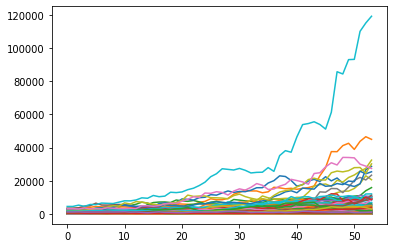

In [39]:
# import pandas as pd
features.plot(legend=False), data

<AxesSubplot:>

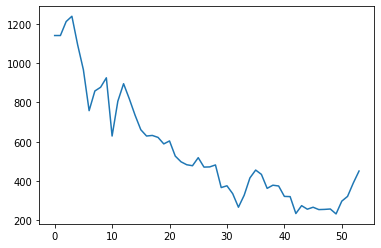

In [48]:
data.iloc[:, 0].plot() # plot

<AxesSubplot:>

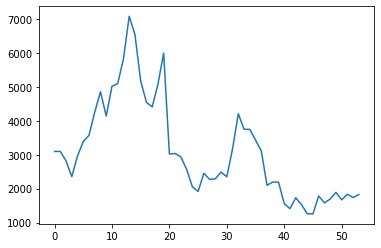

In [54]:
data.iloc[:, 2].plot()

In [49]:
import matplotlib, matplotlib.pyplot as plt
def plot_extrapolated_country(idx):
    x = list(range(54))
    y = data.iloc[:, idx].values

    plt.plot(y)

    z = np.polyfit(x, y, 2)
    f = np.poly1d(z)

    new_points = range(12)
    new_y = []
    for x2 in new_points:
        new_y.append(f(54+x2))

    plt.plot(range(53, 65), new_y)

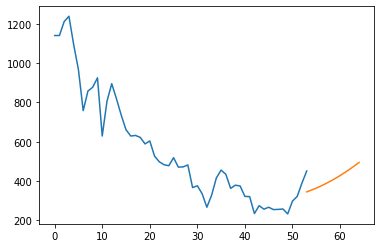

In [51]:
plot_extrapolated_country(0)

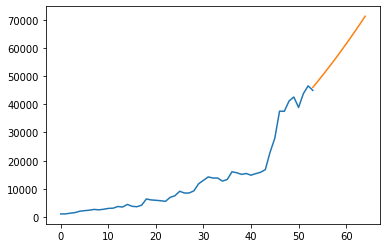

In [52]:
plot_extrapolated_country(1)

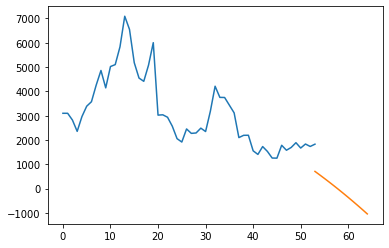

In [55]:
plot_extrapolated_country(2)